In [1]:
import pandas as pd
from tqdm import tqdm_notebook
import pickle
import requests
from gensim.models import Word2Vec

C:\Users\magenta_jy\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

In [3]:
from sklearn.cluster import DBSCAN

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### Stream2Vec

### Load Data

In [7]:
df_stream_info = pd.read_csv("data/stream_info.csv", encoding = "cp949")

In [8]:
df_stream_info.shape

(88970, 3)

In [9]:
df_following_list = pd.read_csv("data/user_following_list.csv", encoding = "cp949")

In [10]:
df_following_list.shape

(21803, 2)

### preprocessing

In [27]:
train = [following_list.split(",") for following_list in df_following_list.following_list]    

In [41]:
# # 활동을 그만둔 스트리머 제거
# train_remove = []
# for i in tqdm_notebook(train):
#     tmp = []
#     for j in range(len(i)):
#         if int(i[j]) in df_stream_info.id.values:
#             tmp.append(i[j])
#     train_remove.append(tmp)

In [30]:
df_stream_info.head()

,id,nickname,name
0,20471342,kritikalmotion,kritikalmotion
1,122966618,Zerglingx3,zerglingx3
2,87931418,Maliki_officiel,maliki_officiel
3,144815955,bigsugar_ow,bigsugar_ow
4,100211792,元寶就是帥,kimya456


In [39]:
# # id를 nickname으로 변경
# train_nickname = []
# for i in tqdm_notebook(train_remove):
#     tmp = []
#     for j in range(len(i)):
#         idx  = pd.Index(df_stream_info.id).get_loc(int(i[j]))
#         tmp.append(df_stream_info.name[idx])
#     train_nickname.append(tmp)

### Model train

In [40]:
# stream2vec_nickname = Word2Vec(train_nickname)

In [159]:
# stream2vec_id = Word2Vec(train_remove)

In [34]:
# with open("model/stream2vec_nick.p", "wb") as f:
#     pickle.dump(stream2vec_nickname, f)
    
# with open("model/stream2vec.p", "wb") as f:
#     pickle.dump(stream2vec_id, f)

### Load model

In [20]:
model = Word2Vec.load("model/stream2vec.gs")

In [21]:
a = model.most_similar("30904062", topn=12)

In [22]:
a

[('137404969', 0.9069118499755859),
 ('102845970', 0.8957206010818481),
 ('46834933', 0.8913339376449585),
 ('147184645', 0.8868926763534546),
 ('131077429', 0.8765517473220825),
 ('131216802', 0.871634840965271),
 ('138515021', 0.8700667023658752),
 ('147090450', 0.8691263794898987),
 ('156748712', 0.8680666089057922),
 ('103825127', 0.8617213368415833),
 ('138542600', 0.8611522912979126),
 ('115122573', 0.855516791343689)]

### Clustering(K means ++)

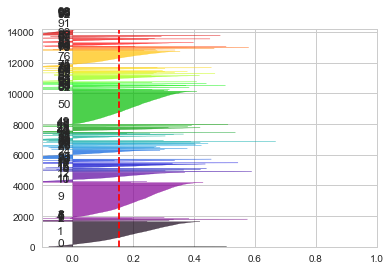

In [29]:
n_clusters = 100

kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", random_state = 0).fit(X)

clusters = kmeans.predict(X)

sil_avg = silhouette_score(X, clusters)
sil_values = silhouette_samples(X, clusters)

plt.xlim([-0.1, 1])
plt.ylim([0, len(X) + (n_clusters + 1) * 10])

y_lower = 20
for k in range(n_clusters):
    ith_cluster_silhouette = sil_values[clusters == k]
    ith_cluster_silhouette.sort()
    
    size_cluster_i = ith_cluster_silhouette.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.spectral(float(k) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette,
                              facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(k))
    # Compute the new y_lower for next plot
    y_lower = y_upper + 20  # 10 for the 0 samples
    
plt.axvline(x=sil_avg, color="red", linestyle="--")

### Display T-SNE

In [22]:
X_annot = list(model.wv.vocab.keys())

In [23]:
# tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(X)

In [24]:
with open("model/tsne.p", "wb") as f:
    pickle.dump(tsne, f)

In [25]:
X_tsne

array([[ 53.13648605,  -3.38643289],
       [ 38.39173126, -78.98429108],
       [ 52.05257416,   0.32328591],
       ..., 
       [-52.28497314,  40.74657822],
       [-28.50997734,  34.2532196 ],
       [-23.21963882,  67.82297516]], dtype=float32)

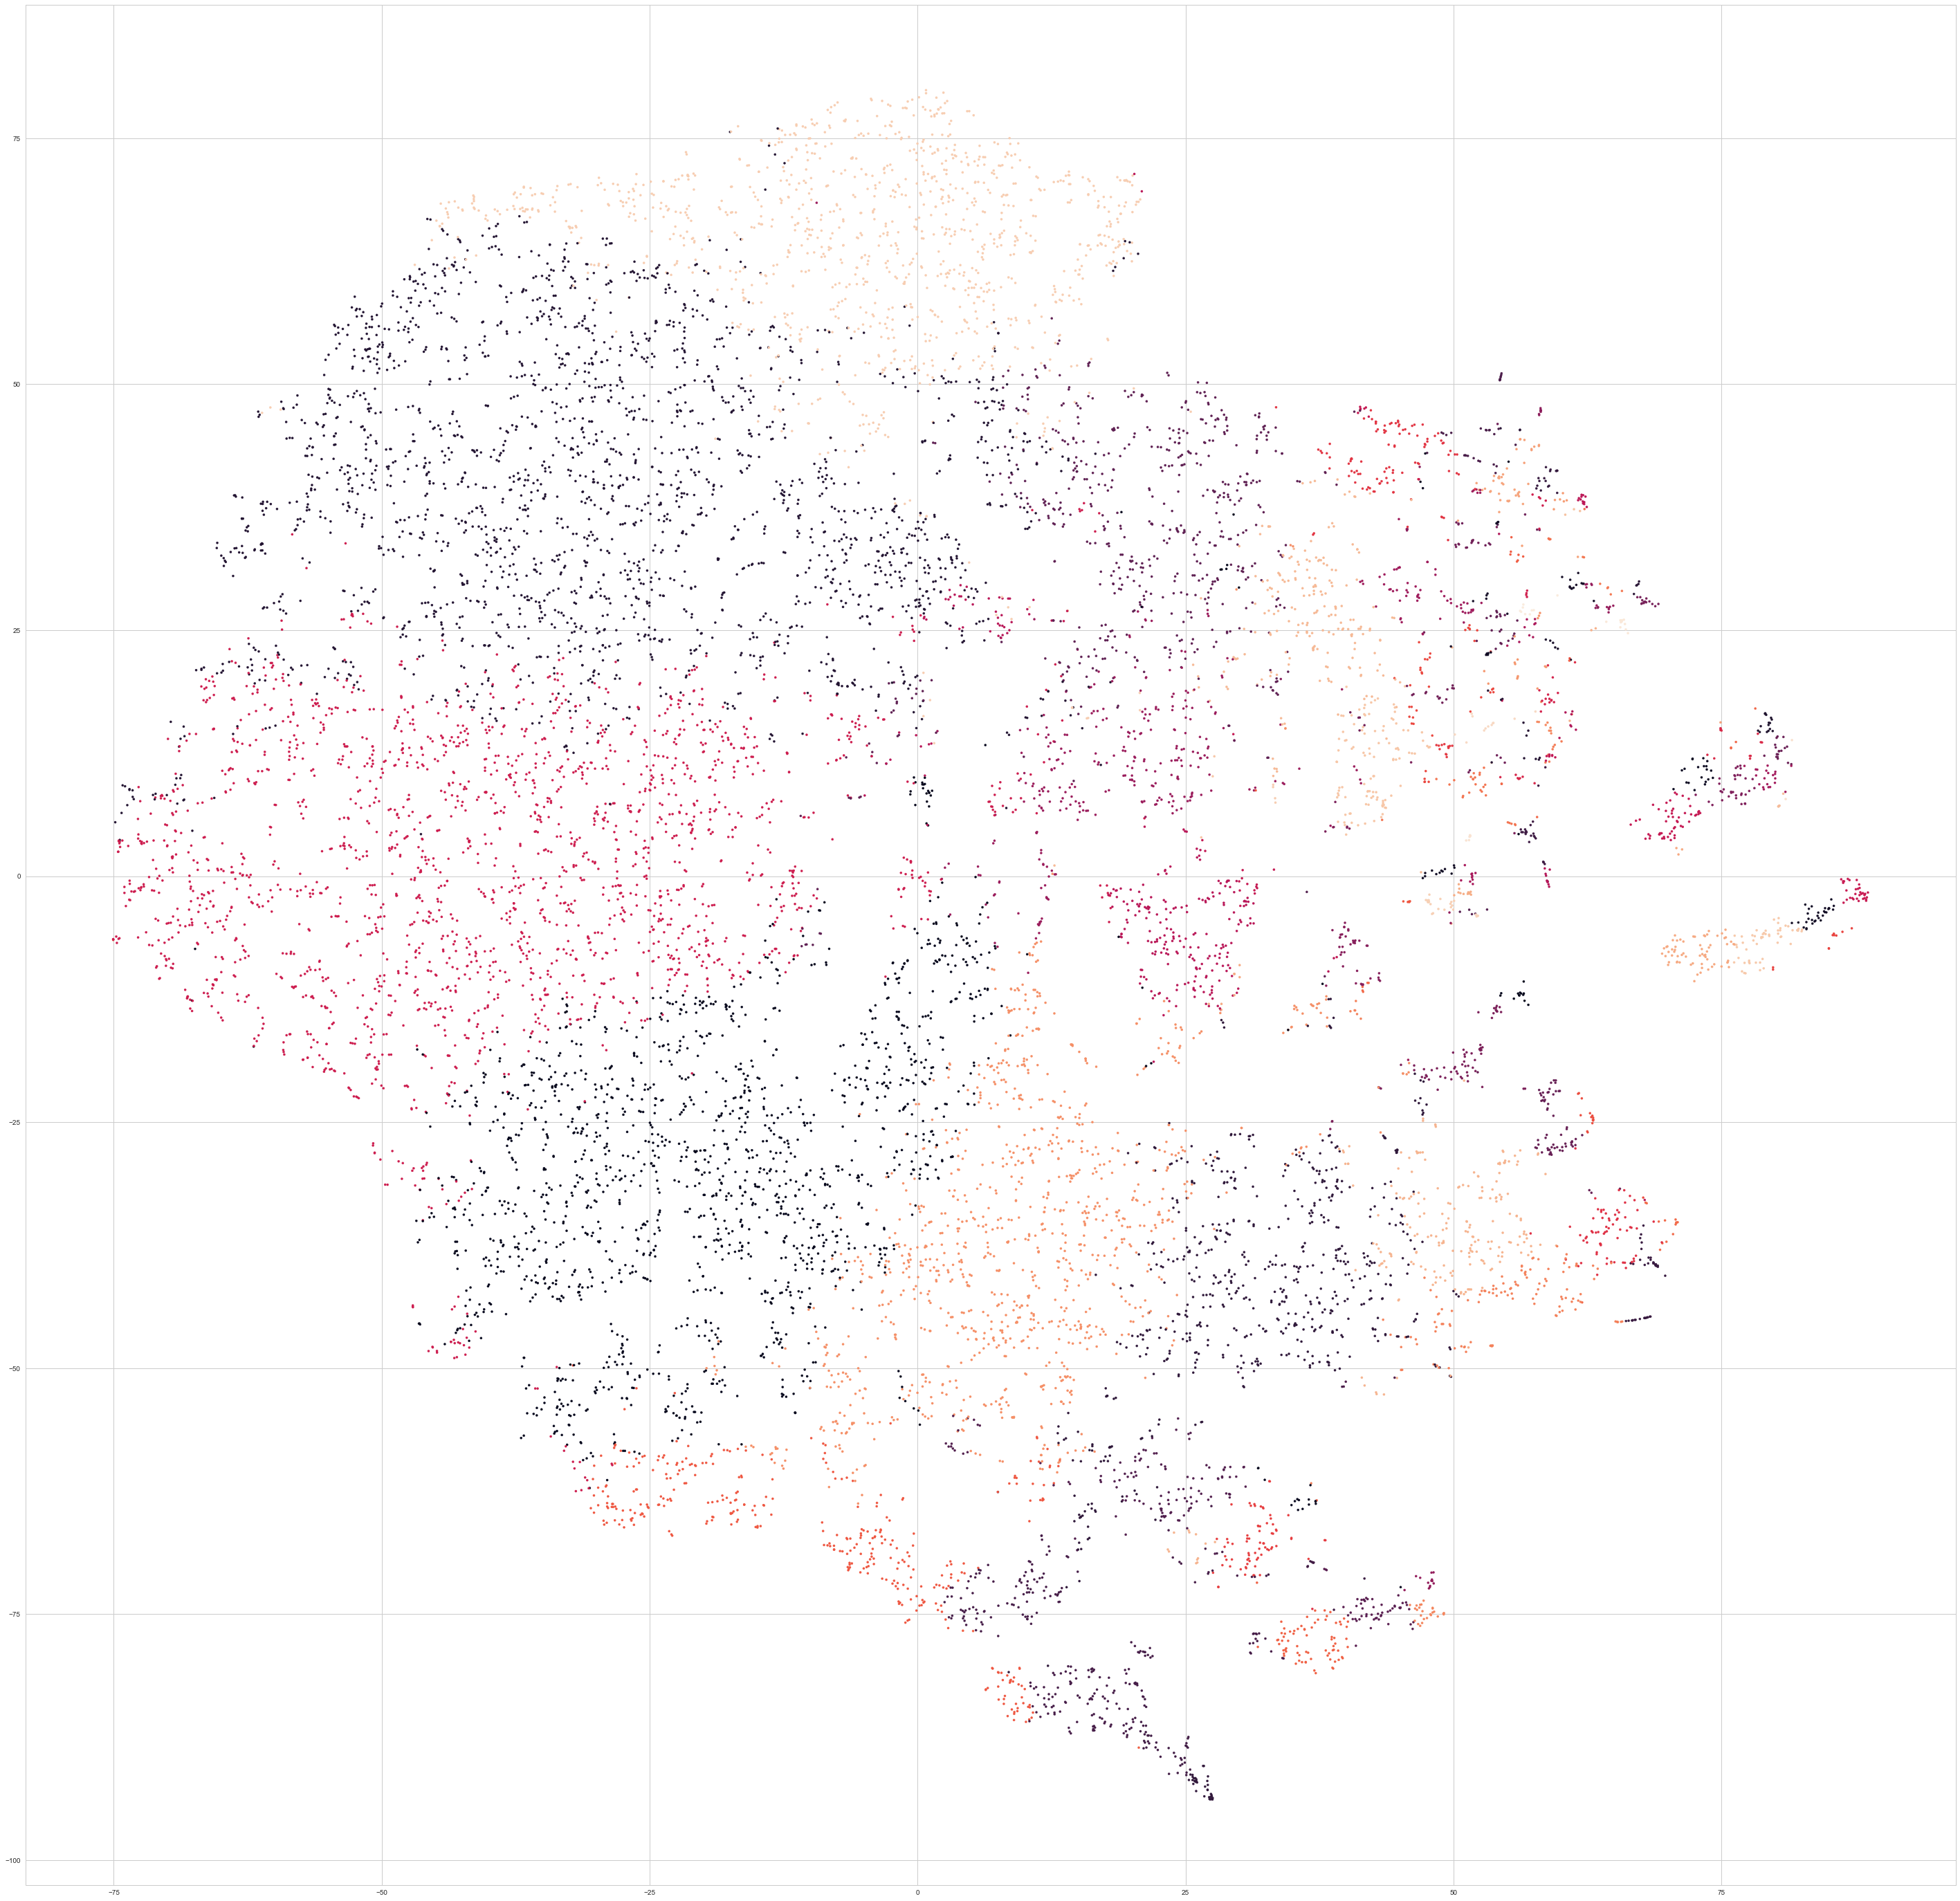

In [30]:
fig, ax = plt.subplots(figsize=(50, 50))
ax.scatter(X_tsne[:,0], X_tsne[:,1], s=10, c=clusters)

### DBSCAN

In [33]:
dbscan = DBSCAN(min_samples = 50).fit_predict(X)

In [34]:
clusters_scans = kmeans.predict(X)

In [23]:
from twitch import TwitchClient

In [46]:
most_similar_streamers = model.most_similar("30904062", topn=12)
most_similar_streamers_info = []
client = TwitchClient(client_id="jh0fr7g4isys0t2fmviygsvk7ez3l9")

for idx in range(len(most_similar_streamers)):
    try:
        channel = client.channels.get_by_id(most_similar_streamers[idx][0])
        print(channel)
        streamer_info = {
                "similar_rate" : most_similar_streamers[idx][1],
                "display_name" : channel["display_name"],
                "image" : channel["logo"],
                "game" : channel["game"],
                "followers" : channel["followers"],
                "views" : channel["views"],
                "link" : channel["url"],
        }
        most_similar_streamers_info.append(streamer_info)
    except Exception as e:
        pass

{'mature': False, 'status': 'PS4pro 띵작 라오어 ㄱㄱ', 'broadcaster_language': 'ko', 'display_name': '소니쇼', 'game': 'The Last of Us', 'language': 'ko', 'id': '137404969', 'name': 'sonycast_', 'created_at': datetime.datetime(2016, 10, 19, 8, 51, 11), 'updated_at': datetime.datetime(2018, 4, 29, 11, 35, 35), 'partner': True, 'logo': 'https://static-cdn.jtvnw.net/jtv_user_pictures/sonycast_-profile_image-ebca8b2445bd0c66-300x300.png', 'video_banner': 'https://static-cdn.jtvnw.net/jtv_user_pictures/be9d9ef0acb9f4e2-channel_offline_image-1920x1080.png', 'profile_banner': 'https://static-cdn.jtvnw.net/jtv_user_pictures/sonycast_-profile_banner-08d380c890a8ce02-480.png', 'profile_banner_background_color': None, 'url': 'https://www.twitch.tv/sonycast_', 'views': 7277116, 'followers': 108283, 'broadcaster_type': 'partner', 'description': '소니쇼 게임방송 (전체이용가)', 'private_video': False, 'privacy_options_enabled': False}
{'mature': False, 'status': ' 데이트 한다 그녀와 오늘의 똥겜은 후후...', 'broadcaster_language': 'ko', '